In [ ]:
# Characterisation can be done by changing settings to qibolab/runcards/tiiq.yml and diagnostics.yml
# These scripts do not save the characterisation results on the runcard; to do so use 
#   ds.backup_config_file()
#   resonator_freq, avg_min_voltage, max_ro_voltage, smooth_dataset, dataset = ds.run_resonator_spectroscopy()
#   ds.save_config_parameter('resonator_freq', resonator_freq, 'characterization', 'single_qubit', qubit)
import pathlib
import os
from qibolab.paths import qibolab_folder
from qibolab import Platform
from qibolab.calibration import utils
# from qibolab.calibration.calibration import Calibration as Diagnostics

script_folder = pathlib.Path(os.path.abspath(''))
# diagnostics_settings = script_folder / 'examples' / 'tii' / "diagnostics.yml"
diagnostics_settings = script_folder / "diagnostics.yml"
runcard = qibolab_folder / 'runcards' / 'qw5q.yml' 

# Create a platform; connect and configure it
platform = Platform('multiqubit', runcard)
platform.connect()
platform.setup()

import pathlib
from scipy.signal import savgol_filter
from qibolab.paths import qibolab_folder
import numpy as np
import matplotlib.pyplot as plt
import yaml

from quantify_core.measurement import MeasurementControl
from quantify_core.measurement.control import Gettable, Settable
from quantify_core.data.handling import set_datadir

from qibolab import Platform
from qibolab.paths import qibolab_folder
from qibolab.calibration import utils
from qibolab.calibration import fitting
from qibolab.pulses import Pulse, ReadoutPulse, Rectangular, Gaussian, Drag
from qibolab.circuit import PulseSequence


class Diagnostics():

    def __init__(self, platform: Platform, settings_file = None,  show_plots=True):
        self.platform = platform
        if not settings_file:
            script_folder = pathlib.Path(__file__).parent
            settings_file = script_folder / "diagnostics.yml"
        self.settings_file = settings_file
        # TODO: Set mc plotting to false when auto calibrates (default = True for diagnostics)
        self.mc, self.pl, self.ins = utils.create_measurement_control('Calibration', show_plots)

    def load_settings(self):
        # Load calibration settings
        with open(self.settings_file, "r") as file:
            self.settings = yaml.safe_load(file)
            self.software_averages = self.settings['software_averages']
            self.software_averages_precision = self.settings['software_averages_precision']
            self.max_num_plots = self.settings['max_num_plots']

    def reload_settings(self):
        self.load_settings()

    #--------------------------#
    # Single qubit experiments #
    #--------------------------#

    def run_resonator_spectroscopy(self, qubit=0):
        platform = self.platform
        platform.reload_settings()
        mc = self.mc

        sequence = PulseSequence()
        ro_pulse = platform.qubit_readout_pulse(qubit, start = 0)
        sequence.add(ro_pulse)

        self.reload_settings()
        self.lowres_width = self.settings['resonator_spectroscopy']['lowres_width']
        self.lowres_step = self.settings['resonator_spectroscopy']['lowres_step']
        self.highres_width = self.settings['resonator_spectroscopy']['highres_width']
        self.highres_step = self.settings['resonator_spectroscopy']['highres_step']
        self.precision_width = self.settings['resonator_spectroscopy']['precision_width']
        self.precision_step = self.settings['resonator_spectroscopy']['precision_step']

        self.pl.tuids_max_num(self.max_num_plots)
        platform.qrm[qubit].lo.frequency = platform.characterization['single_qubit'][qubit]['resonator_freq'] - ro_pulse.frequency
        #Fast Sweep
        if (self.software_averages !=0):
            scanrange = utils.variable_resolution_scanrange(self.lowres_width, self.lowres_step, self.highres_width, self.highres_step)
            mc.settables(platform.qrm[qubit].lo.settable_frequency)
            mc.setpoints(scanrange + platform.qrm[qubit].lo.frequency)
            mc.gettables(Gettable(ROController(platform, sequence, qubit)))
            platform.start() 
            dataset = mc.run("Resonator Spectroscopy Fast", soft_avg=self.software_averages)
            platform.stop()
            platform.qrm[qubit].lo.frequency = dataset['x0'].values[dataset['y0'].argmin().values]
            avg_max_voltage = np.mean(dataset['y0'].values[:(self.lowres_width//self.lowres_step)]) * 1e6

        # Precision Sweep
        if (self.software_averages_precision !=0):
            scanrange = np.arange(-self.precision_width, self.precision_width, self.precision_step)
            mc.settables(platform.qrm[qubit].lo.settable_frequency)
            mc.setpoints(scanrange + platform.qrm[qubit].lo.frequency)
            mc.gettables(Gettable(ROController(platform, sequence, qubit)))
            platform.start()
            dataset = mc.run("Resonator Spectroscopy Precision", soft_avg=self.software_averages_precision)
            platform.stop()

        # Fitting
        smooth_dataset = savgol_filter(dataset['y0'].values, 25, 2)
        # resonator_freq = dataset['x0'].values[smooth_dataset.argmax()] + ro_pulse.frequency
        min_ro_voltage = smooth_dataset.min() * 1e6

        f0, BW, Q = fitting.lorentzian_fit("last", min, "Resonator_spectroscopy")
        resonator_freq = (f0*1e9 + ro_pulse.frequency)

        print(f"\nResonator Frequency = {resonator_freq}")
        return resonator_freq, avg_max_voltage, min_ro_voltage, smooth_dataset, dataset
        
class ROController():
    # Quantify Gettable Interface Implementation
    label = ['Amplitude', 'Phase','I','Q']
    unit = ['V', 'Radians','V','V']
    name = ['A', 'Phi','I','Q']

    def __init__(self, platform, sequence, qubit):
        self.platform = platform
        self.sequence = sequence
        self.qubit = qubit

    def get(self):
        results = self.platform.execute_pulse_sequence(self.sequence)
        return list(list(results.values())[0].values())[0] #TODO: Replace with the particular acquisition


In [ ]:


# create a diagnostics/calibration object
ds = Diagnostics(platform, diagnostics_settings)

qubit = 0


In [ ]:

for qubit in range(5):
    resonator_freq, avg_min_voltage, max_ro_voltage, smooth_dataset, dataset = ds.run_resonator_spectroscopy(qubit)


S4g module 3: current 0.000000 mA too low for set span,current set to min value: 0.000000 mA
S4g module 3: current 0.000000 mA too low for set span,current set to min value: 0.000000 mA
S4g module 3: current 0.000000 mA too low for set span,current set to min value: 0.000000 mA
S4g module 3: current 0.000000 mA too low for set span,current set to min value: 0.000000 mA
S4g module 3: current 0.000000 mA too low for set span,current set to min value: 0.000000 mA


Current too low for set span, DAC set to min value
Current too low for set span, DAC set to min value
Current too low for set span, DAC set to min value
Current too low for set span, DAC set to min value
Current too low for set span, DAC set to min value
Starting iterative measurement...
 98% completed | elapsed time:     92s | time left:      1s  

S4g module 3: current 0.000000 mA too low for set span,current set to min value: 0.000000 mA
S4g module 3: current 0.000000 mA too low for set span,current set to min value: 0.000000 mA
S4g module 3: current 0.000000 mA too low for set span,current set to min value: 0.000000 mA
S4g module 3: current 0.000000 mA too low for set span,current set to min value: 0.000000 mA
S4g module 3: current 0.000000 mA too low for set span,current set to min value: 0.000000 mA


100% completed | elapsed time:     93s | time left:      0s  
100% completed | elapsed time:     93s | time left:      0s  Current too low for set span, DAC set to min value
Current too low for set span, DAC set to min value
Current too low for set span, DAC set to min value
Current too low for set span, DAC set to min value
Current too low for set span, DAC set to min value
Starting iterative measurement...
 97% completed | elapsed time:     22s | time left:      0s  

S4g module 3: current 0.000000 mA too low for set span,current set to min value: 0.000000 mA
S4g module 3: current 0.000000 mA too low for set span,current set to min value: 0.000000 mA
S4g module 3: current 0.000000 mA too low for set span,current set to min value: 0.000000 mA
S4g module 3: current 0.000000 mA too low for set span,current set to min value: 0.000000 mA


100% completed | elapsed time:     22s | time left:      0s  
100% completed | elapsed time:     22s | time left:      0s  Current too low for set span, DAC set to min value
Current too low for set span, DAC set to min value
Current too low for set span, DAC set to min value
Current too low for set span, DAC set to min value


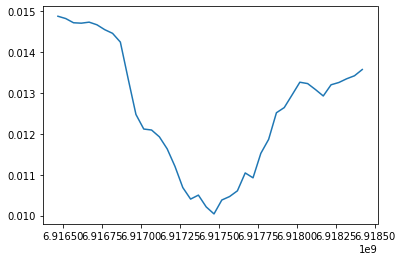

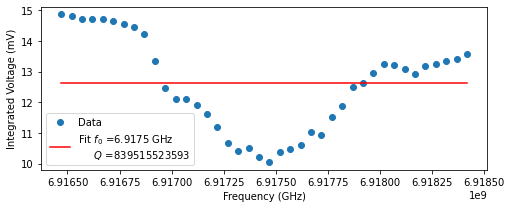


Resonator Frequency = 6937470000.0


In [4]:
qubit = 0
resonator_freq, avg_min_voltage, max_ro_voltage, smooth_dataset, dataset = ds.run_resonator_spectroscopy(qubit)